# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Name hier eintragen</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

16384


d:\dev\hpc-m2\.venv\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

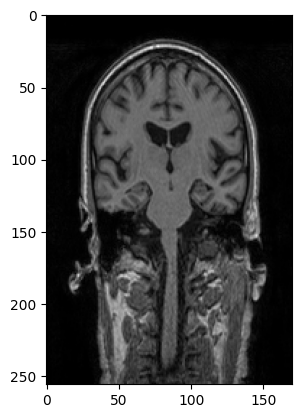

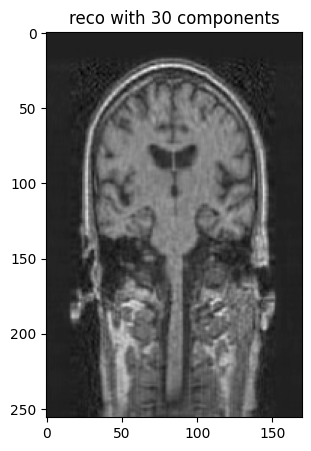

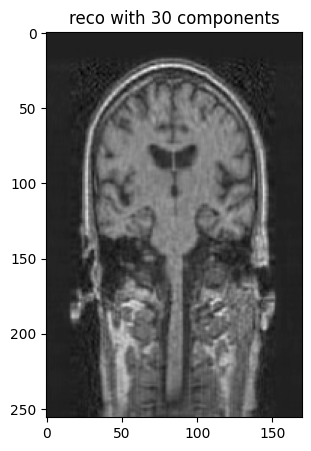

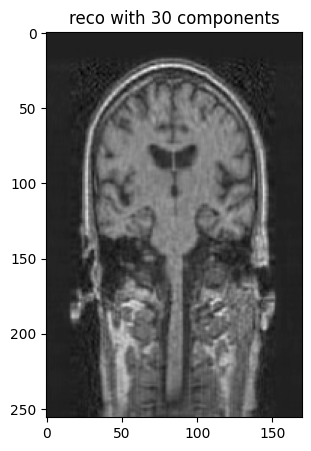

In [2]:
### BEGIN SOLUTION
import imageio.v2 as imageio
import cupy as cp
from cupyx.profiler import benchmark
from numba import cuda, float32

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import timeit
import random
import pickle
from tqdm import tqdm


image_path = "./adni_png/001/m4-2_slice145.png"
image_brain = imageio.imread(image_path)

plt.imshow(image_brain, cmap='gray')

# normalize data
image_brain = image_brain - image_brain.min() / image_brain.max() - image_brain.min() 

# compute SVD
u,s,vt = np.linalg.svd(image_brain, full_matrices=False)

## helper function to plot reconstructed image
def plot_reco(reco, k):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')


## reconstruct image
k = 30  # Number of components to keep
u_gpu = cp.asarray(u)
s_gpu = cp.asarray(s)
vt_gpu = cp.asarray(vt)


# different variants not using a kernel
def reconstruct_svd_cp(u, s, vt, k):
    return cp.dot(u[:, :k], cp.dot(cp.diag(s[:k]), vt[:k, :]))

def reconstruct_svd_cp_einsum(u, s, vt, k):
    return cp.einsum('ij,j,jk', u[:, :k], s[:k], vt[:k, :])

def reconstruct_svd_cp_broadcast(u, s, vt, k):
    return cp.dot(u[:, :k], cp.multiply(s[:k].reshape(-1, 1), vt[:k, :]))

## validate results by plotting
plot_reco(cp.asnumpy(reconstruct_svd_cp(u_gpu, s_gpu, vt_gpu, k)), k)
plot_reco(cp.asnumpy(reconstruct_svd_cp_einsum(u_gpu, s_gpu, vt_gpu, k)), k)
plot_reco(cp.asnumpy(reconstruct_svd_cp_broadcast(u_gpu, s_gpu, vt_gpu, k)), k)

### END SOLUTION

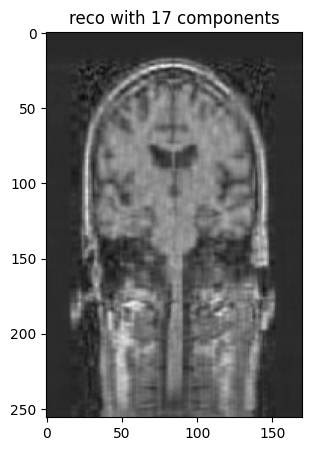

In [19]:
# Kernel implementiert in CUDA C
kernel_code = """
extern "C" __global__
void reconstruct_svd(const float* u, const float* s, const float* vt, float* C,
            int rows_u, int cols_u, int rows_vt, int cols_vt, int k)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    // check if k is in range
    if (k > rows_u || k > cols_vt || k > rows_vt || k > cols_u) {
        return;
    }
    if (k < 0) {
        return;
    }
    // check if i and j are in bounds
    if (i >= rows_u || j >= cols_vt) {
        return;
    }

    float sum = 0;
    for (int l = 0; l < k; ++l) {
        sum += u[i * cols_u + l] * s[l] * vt[l * cols_vt + j];
    }
    C[i * cols_vt + j] = sum;
}
"""

reconstruct_svd_kernel = cp.RawKernel(kernel_code, 'reconstruct_svd')

u, s, vt = np.linalg.svd(image_brain, full_matrices=False)
k = 17

u = u[:, 0:k]
s = s[0:k]
vt = vt[0:k, :]

C = np.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.asarray(C, dtype=np.float32)

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_kernel(blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k))

C = cp.asnumpy(C_gpu)

plot_reco(C, k)

Die Kernelfunktion funktioniert!

In [4]:
# load reconstruction_times.pkl as dataframe
df = pd.read_pickle('reconstruction_times.pkl')
df['cpu'] = True
ks = df['k'].unique()

In [5]:
# measure time

# warmup
reconstruct_svd_kernel(blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k))

# measure kernel time
reconstruction_times_cuda = []
for k in ks:
    elapsed = benchmark(reconstruct_svd_kernel, (blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k)), n_repeat=10).gpu_times.sum()
    reconstruction_times_cuda.append(("reconstruct_svd_kernel", k, elapsed))


cupy_methods = [reconstruct_svd_cp, reconstruct_svd_cp_einsum, reconstruct_svd_cp_broadcast]

for method in cupy_methods:
    # warmup
    method(u_gpu, s_gpu, vt_gpu, k)
    for k in ks:
        elapsed = timeit.timeit(lambda: method(u_gpu, s_gpu, vt_gpu, k), globals=globals(), number=10)
        reconstruction_times_cuda.append((method.__name__, k, elapsed))

reconstruction_times_cuda = pd.DataFrame(reconstruction_times_cuda, columns=['method', 'k', 'time'])
reconstruction_times_cuda['cpu'] = False

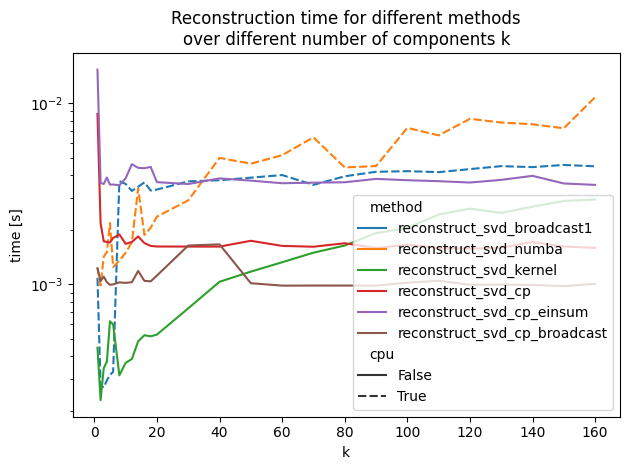

In [6]:
# concatenate times
df = pd.concat([df, reconstruction_times_cuda])

# plot times
sns.lineplot(x="k", y="time", hue="method", style="cpu", data=df[df["method"].isin(["reconstruct_svd_numba", "reconstruct_svd_broadcast1", "reconstruct_svd_kernel", "reconstruct_svd_cp", "reconstruct_svd_cp_einsum", "reconstruct_svd_cp_broadcast"])])
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("time [s]")
plt.title("Reconstruction time for different methods\nover different number of components k")
plt.tight_layout()
plt.show()


Die Aufteilung der Berechnungen auf CPU und GPU ist wie folgt:
- Die CPU schneidet die Matrizen so, dass nur die ersten k Reihen/Spalten verwendet werden.
- Die GPU erledigt die eigentliche GPU-Rekonstruktion.

Ich habe mir die beiden Libraries Cupy und Numba angesehen. Mir sind folgende Unterschiede aufgefallen, wann welche Library verwendet werden kann:
- CuPy:
 - Wenn der Code schon vektorisiert ist (z.B. mit numpy)
 - und ich den Code nicht gross anpassen will (da CuPy ein drop-in replacement für numpy ist)
- Numba:
  - Wenn der Code noch nicht vektorisiert ist (z.B. enthält for loops) und der Code deshalb kompileriert ist.
Da mein Code aus dem ersten Teil schon vektorisiert ist, habe ich mich für CuPy entschieden. Was ich mir aber nicht überlegt habe: Ich muss das ganze in einem Kernel implementieren und das geht in Numba viel einfacher. Deshalb habe ich einen RawKernel in CuPy implementiert (`reconstruct_svd_kernel`) und noch drei varianten aus dem ersten Teil mit Hilfe des drop-in replacements von CuPy implementiert (`reconstruct_svd_cp`, `reconstruct_svd_cp_einsum` und `reconstruct_svd_cp_broadcast`).

Wie in der Grafik oben zu entnehmen ist, sind alle GPU-Varianten nach einem k von so ca. 35 auf einem ADNI-Bild schneller als die CPU_Varianten. Die drop-in replacements von CuPy haben eine konstante Performance (unabhängig von k), während meine Kernel-Funktion eine Performance hat, die mit steigendem k zunimmt. 

#### 5.2 GPU-Kernel Performance

##### 5.3.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [7]:
# create new test matrices
debug = False
if debug:
    test_image_1 = np.random.rand(random.randint( 80, 100), random.randint( 80, 100))
    test_image_2 = np.random.rand(random.randint(200, 250), random.randint(200, 250))
    test_image_3 = np.random.rand(random.randint(400, 450), random.randint(400, 450))
else:
    test_image_1 = np.random.rand(random.randint( 800, 1000), random.randint( 800, 1000))
    test_image_2 = np.random.rand(random.randint(2000, 2500), random.randint(2000, 2500))
    test_image_3 = np.random.rand(random.randint(4000, 4500), random.randint(4000, 4500))
# huge_image = np.random.rand(8192, 8192)

images = {
    'test_image_1': test_image_1,
    'test_image_2': test_image_2,
    'test_image_3': test_image_3,
    # 'huge_image': huge_image
}

decompositions = {}
for name, image in tqdm(images.items()):
    # move image to gpu
    image_gpu = cp.asarray(image, dtype=np.float32)
    u_gpu, s_gpu, vt_gpu = cp.linalg.svd(image_gpu, full_matrices=False)

    u = cp.asnumpy(u_gpu)
    s = cp.asnumpy(s_gpu)
    vt = cp.asnumpy(vt_gpu)

    # release memory
    del u_gpu, s_gpu, vt_gpu, image_gpu

    decompositions[name] = {
        'u': u,
        's': s,
        'vt': vt
    }

100%|██████████| 3/3 [00:34<00:00, 11.62s/it]


In [8]:
# from part 1
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:,:k] * s[:k] @ vt[:k,:]
    ### END SOLUTION

    return reco

# add comparison times of CPU reconstruction
cpu_times = []
for name, decomposition in tqdm(decompositions.items()):
    u = decomposition['u']
    s = decomposition['s']
    vt = decomposition['vt']
    
    k = min(u.shape[1], vt.shape[0]) 

    # measure time
    elapsed = timeit.timeit(lambda: reconstruct_svd_broadcast1(u, s, vt, k), globals=globals(), number=10)
    cpu_times.append({
        'name': name,
        'image_size': (u.shape[0], vt.shape[1]),
        'k': k,
        'time': elapsed
    })

cpu_times = pd.DataFrame(cpu_times, columns=['name', 'image_size', 'k', 'time'])
cpu_times

100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


,name,image_size,k,time
0,test_image_1,"(934, 889)",889,0.067667
1,test_image_2,"(2221, 2407)",2221,0.677510
2,test_image_3,"(4273, 4447)",4273,4.069207


In [9]:
block_configurations = []
for i in range(2, 6):
    block_configurations.append((2**i, 2**i))
    block_configurations.append((2**i, 2**(i-1)))
    block_configurations.append((2**(i-1), 2**i))
    block_configurations.append((2**(i-1), 2**(i+1)))
    block_configurations.append((2**(i-2), 2**(i+1)))
    block_configurations.append((2**(i-2), 2**(i+2)))

In [10]:
### BEGIN SOLUTION
def measure_kernel_reconstruction(threads_per_block, decomposed_image):
    u, s, vt = decomposed_image['u'], decomposed_image['s'], decomposed_image['vt']
    k = min(u.shape[1], vt.shape[0]) // 3 # use 1/3 of components

    blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    u_gpu = cp.asarray(u, dtype=np.float32)
    s_gpu = cp.asarray(s, dtype=np.float32)
    vt_gpu = cp.asarray(vt, dtype=np.float32)
    C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

    result = benchmark(reconstruct_svd_kernel, (blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k)), n_repeat=10)
    return {
                "result": result,
                "image_size": (u.shape[0], vt.shape[1]),
                "k": k,
                "blocks_per_grid": blocks_per_grid,
                "threads_per_block": threads_per_block,
            }

experiment_results = []
for image in decompositions.keys():
    for threads_per_block in block_configurations:
        experiment_results.append(measure_kernel_reconstruction(threads_per_block, decompositions[image]))
### END SOLUTION

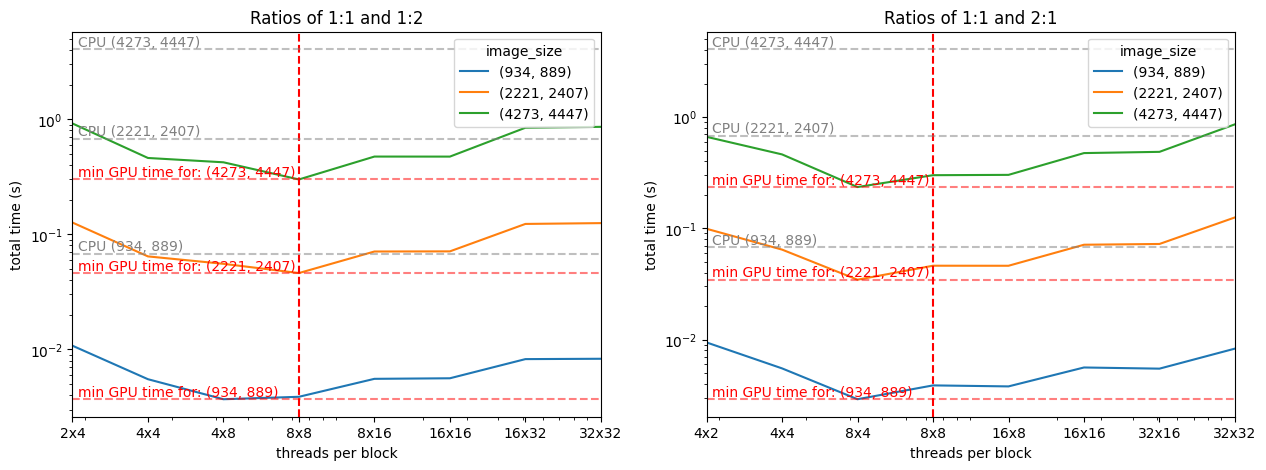

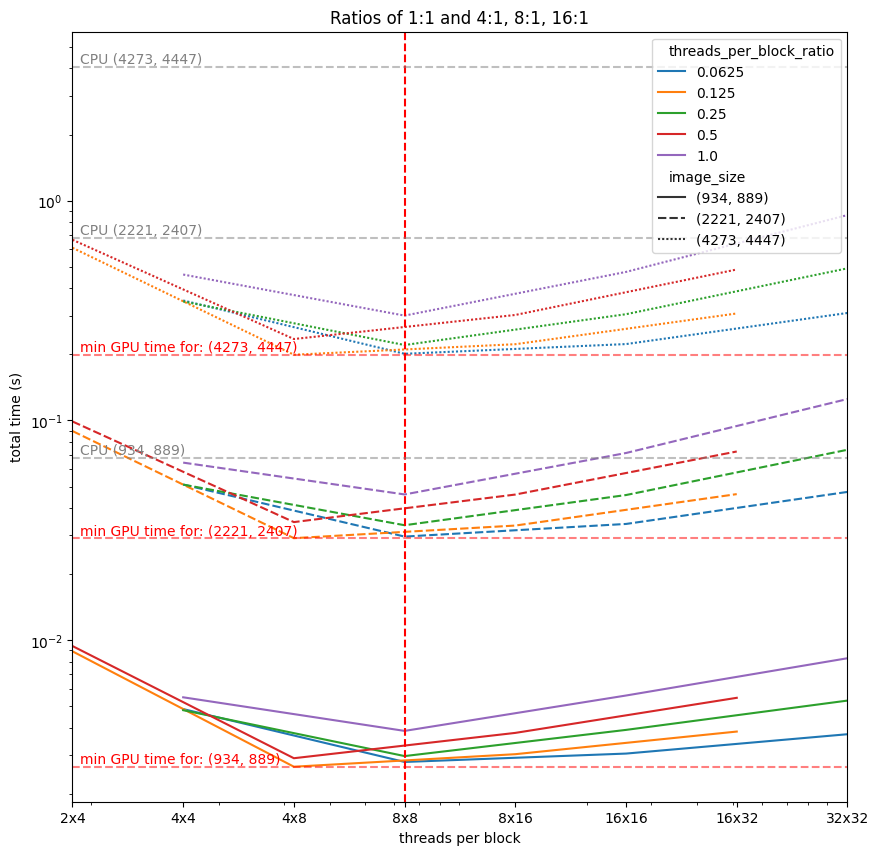

In [21]:
# turn results into dataframe
def convert_experiment_results_to_df(experiment_results):
    df = pd.DataFrame(experiment_results)
    df['gpu_time'] = df['result'].apply(lambda x: x.gpu_times.mean())
    df['cpu_time'] = df['result'].apply(lambda x: x.cpu_times.mean())
    df['total_time'] = df['gpu_time'] + df['cpu_time']
    df['gput_time_std'] = df['result'].apply(lambda x: x.gpu_times.std())
    df['cput_time_std'] = df['result'].apply(lambda x: x.cpu_times.std())
    df['blocks_per_grid_tot'] = df['blocks_per_grid'].apply(lambda x: x[0] * x[1])
    df['blocks_per_grid_str'] = df['blocks_per_grid'].apply(lambda x: f"{x[0]}x{x[1]}")
    df['threads_per_block_ratio'] = df['threads_per_block'].apply(lambda x: x[0] / x[1])
    df['threads_per_block_tot'] = df['threads_per_block'].apply(lambda x: x[0] * x[1])
    df['threads_per_block_str'] = df['threads_per_block'].apply(lambda x: f"{x[0]}x{x[1]}")
    # convert cpu_times to dictionary with image_size as key and time as value
    cpu_time_per_image_size = cpu_times.set_index('image_size')['time'].to_dict()
    df['speedup'] = df.apply(lambda x: cpu_time_per_image_size[x['image_size']] / x['total_time'], axis=1)
    
    df = df.sort_values(by=['gpu_time'])
    return df


def convert_ratios_to_fractions(labels):
    fractions = []
    for label in labels:
        label_num = float(label)
        fractions.append(f"{int(1/label_num)}:1" if label_num < 1 else f"1:{int(label_num)}")
    return fractions


def sub_plot_results(ax, data, title, y="total_time", hue="image_size", style=None, palette=None, ratio=None):
    sns.lineplot(x="threads_per_block_tot", y=y, hue=hue, style=style, palette=palette, data=data, ax=ax)
    # draw a vertical line at 8x8 (64)
    ax.axvline(x=64, color='r', linestyle='--')
    # plot a red horizontal line for the minimal gpu time for each image size
    for image_size in data['image_size'].unique():
        min_gpu_time = data[data['image_size'] == image_size][y].min()
        line = ax.axhline(y=min_gpu_time, color='r', linestyle='--', alpha=0.5)
        # draw text above the line on the left
        ax.text(0.01, min_gpu_time, f"min GPU time for: {image_size}", transform=line.get_transform(), color='r', ha="left", va="bottom")
    # plot a grey horizontal line for the cpu time for each image size
    for image_size in cpu_times['image_size'].unique():
        cpu_time = cpu_times[cpu_times['image_size'] == image_size]['time'].mean()
        line = ax.axhline(y=cpu_time, color='grey', linestyle='--', alpha=0.5)
        # draw text above the line on the left
        ax.text(0.01, cpu_time, f"CPU {image_size}", transform=line.get_transform(), color='grey', ha="left", va="bottom")
    plt.sca(ax)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(8, 1024)
    ticks = [8, 16, 32, 64, 128, 256, 512, 1024]
    if ratio == "1:2":
        labels = ["2x4", "4x4", "4x8", "8x8", "8x16", "16x16", "16x32", "32x32"]
    else:
        labels = ["4x2", "4x4", "8x4", "8x8", "16x8", "16x16", "32x16", "32x32"]
    plt.xticks(ticks, labels)
    plt.xlabel("threads per block")
    plt.ylabel("total time (s)")
    plt.title(title)


df = convert_experiment_results_to_df(experiment_results)

def plot_ratios(df: pd.DataFrame):
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sub_plot_results(ax1, df[df['threads_per_block_ratio'].isin([1, 2])], "Ratios of 1:1 and 1:2", ratio="1:2")
    sub_plot_results(ax2, df[df['threads_per_block_ratio'].isin([1, 0.5])], "Ratios of 1:1 and 2:1")

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sub_plot_results(ax, df[df['threads_per_block_ratio'].isin([1, 0.5, 0.25, 0.125, 0.0625])], "Ratios of 1:1 and 4:1, 8:1, 16:1", hue="threads_per_block_ratio", style="image_size", palette="tab10", ratio="1:2")


plot_ratios(df)

In der obersten Grafik links ist die Performance für die Rekonstruktion mit Blockgrössen im Verhältnis von 1:1 und 1:2 zu sehen. Und in der links mit den Blockgrössen 1:1 und 2:1. Dabei ist zu beobachten, dass in der linken Grafik die beste Performance bei 8x8 liegt, respektive für das kleinste Bild ist die Konfiguration 4x8 am schnellsten. Bei der rechten Grafik ist die beste Performance bei 8x4 überall besser.

Der Speedup gegenüber der CPU beträgt bei allen Konfigurationen ca. 20-30x.

Interessant, dass das Seitenverhältnis der Blöcke einen so grossen Einfluss auf die Performance hat. Deshalb habe ich Blockkonfigurationen mit einem Seitenverhältnis von kleiner als 1 noch genauer untersucht (1:2, 1:4, 1:8, 1:16). Diese Ergebnisse sind in der unteren Grafik zu sehen. Die beste Performance hat die Konfiguration 2x16 über alle Bilder. 

Es macht Sinn, dass in beiden Tests Blockkonfigurationen mit einer Totalen Anzahl an Threads von 32 die beste Performance erreichen, da die NVIDIA GPU in jedem Warp 32 Threads gleichzeitig ausführt. Wenn man mehr Threads pro Block hat, muss CUDA diese Threads auf mehrere Warps aufteilen, was weniger effizient ist.

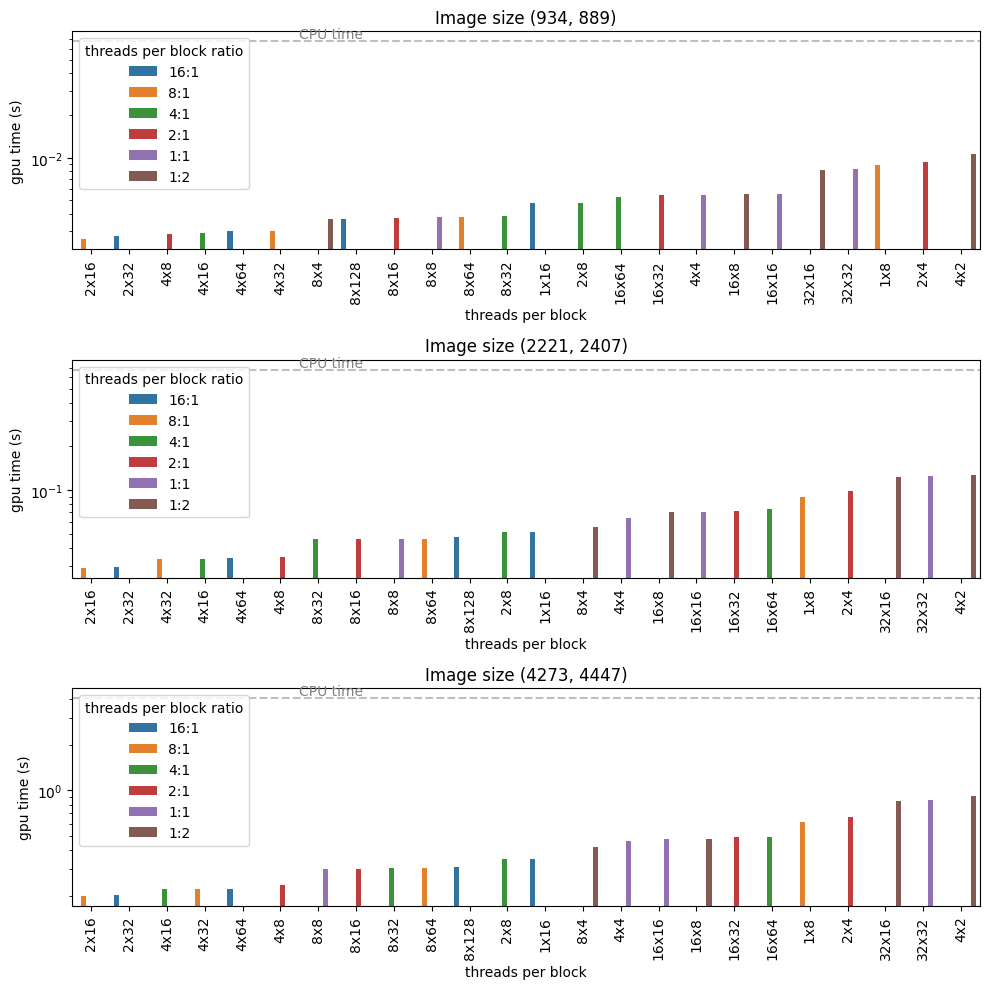

In [12]:
def plot_time_over_ratios(df):
    # create three subplots (one for each image size) and plot the results as bar charts with error bars
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    image_sizes = df['image_size'].unique()

    for i, image_size in enumerate(image_sizes):
        ax = axs[i]
        data = df[df['image_size'] == image_size]
        sns.barplot(x="threads_per_block_str", y="gpu_time", hue="threads_per_block_ratio", data=data, ax=ax)
        ax.set_xlabel("threads per block")
        ax.set_ylabel("gpu time (s)")
        ax.set_title(f"Image size {image_size}")
        ax.set_yscale("log")
        for item in ax.get_xticklabels():
            item.set_rotation(90)

        # use ratios in legend
        handles, labels = ax.get_legend_handles_labels()
        labels = convert_ratios_to_fractions(labels)
        ax.legend(handles, labels, loc='upper left', title='threads per block ratio')

        cpu_time = cpu_times[cpu_times['image_size'] == image_size]['time'].mean()
        line = ax.axhline(y=cpu_time, color='grey', linestyle='--', alpha=0.5)
        ax.text(0.25, cpu_time, f"CPU time", transform=line.get_transform(), color='grey', ha="left", va="bottom")
        
    plt.tight_layout()
    plt.show()

plot_time_over_ratios(df)

Auch diese Grafik zeigt, dass die GPU bei allen Konfigurationen ca. 20-30x schneller ist als die CPU. Hier lässt sich deutlich erkennen, dass die beste Konfiguration bei 2x16 liegt, dicht gefolgt von 2x32.

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

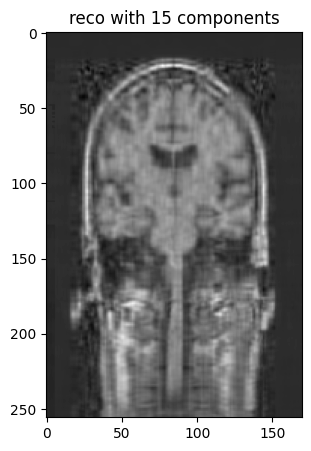

In [13]:
### BEGIN SOLUTION
@cuda.jit
def reconstruct_svd_numba(u, s, vt, C, k):
    i, j = cuda.grid(2)
    if i < u.shape[0] and j < vt.shape[1]:
        sum = 0
        for l in range(k):
            sum += u[i, l] * s[l] * vt[l, j]
        C[i, j] = sum

TBP = 16
@cuda.jit
def reconstruct_svd_numba_shared_memory(u, s, vt, C, k):
    """
    This kernel uses shared memory to speed up the computation.
    
    :param u: u matrix
    :param s: s vector
    :param vt: vt matrix
    :param C: result matrix
    :param k: number of components to keep
    """
    block_i = cuda.blockIdx.x
    block_j = cuda.blockIdx.y
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    i, j = cuda.grid(2)

    tmp = 0.0
    
    u_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    vt_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    s_shared = cuda.shared.array(shape=(TBP), dtype=float32)

    num_blocks = math.ceil(min(k, u.shape[1]) / TBP)
    for m in range(num_blocks):
        u_shared[thread_i, thread_j] = u[block_i * TBP + thread_i, m * TBP + thread_j]
        vt_shared[thread_i, thread_j] = vt[m * TBP + thread_i, block_j * TBP + thread_j]
        if thread_j == 0:
            s_shared[thread_i] = s[m * TBP + thread_i]

        cuda.syncthreads()
        for l in range(TBP):
            if l + m * TBP < k:
                tmp += u_shared[thread_i, l] * s_shared[l] * vt_shared[l, thread_j]
        cuda.syncthreads()

    C[i, j] = tmp


u, s, vt = np.linalg.svd(image_brain, full_matrices=False)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

k = 15

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

C = cp.asnumpy(C_gpu)
plot_reco(C, k)

### END SOLUTION

In [14]:
import time

# mimic cupy benchmark result: https://docs.cupy.dev/en/stable/reference/generated/cupyx.profiler._time._PerfCaseResult.html#cupyx.profiler._time._PerfCaseResult
class BenchmarkResult:
    def __init__(self, gpu_times: np.ndarray, cpu_times: np.ndarray):
        self.gpu_times = gpu_times
        self.cpu_times = cpu_times


def measure_numba_kernel_reconstruction(threads_per_block, decomposed_image):
    u, s, vt = decomposed_image['u'], decomposed_image['s'], decomposed_image['vt']
    k = min(u.shape[1], vt.shape[0]) // 3 # use 1/3 of components

    
    @cuda.jit
    def reconstruct_svd_numba_shared_memory(u, s, vt, C, k):
        """
        This kernel uses shared memory to speed up the computation.
        
        :param u: u matrix
        :param s: s vector
        :param vt: vt matrix
        :param C: result matrix
        :param k: number of components to keep
        """
        block_i = cuda.blockIdx.x
        block_j = cuda.blockIdx.y
        thread_i = cuda.threadIdx.x
        thread_j = cuda.threadIdx.y
        i, j = cuda.grid(2)

        tmp = 0.0
        
        u_shared = cuda.shared.array(shape=(threads_per_block[0], threads_per_block[1]), dtype=float32)
        vt_shared = cuda.shared.array(shape=(threads_per_block[0], threads_per_block[1]), dtype=float32)
        s_shared = cuda.shared.array(shape=(threads_per_block[0]), dtype=float32)

        num_blocks = math.ceil(min(k, vt.shape[0], u.shape[1]) / threads_per_block[0])
        for m in range(num_blocks):
            u_shared[thread_i, thread_j] = u[block_i * threads_per_block[0] + thread_i, m * threads_per_block[1] + thread_j]
            vt_shared[thread_i, thread_j] = vt[m * threads_per_block[0] + thread_i, block_j * threads_per_block[1] + thread_j]
            if thread_j == 0:
                s_shared[thread_i] = s[m * threads_per_block[0] + thread_i]

            cuda.syncthreads()
            for l in range(threads_per_block[0]):
                if l + m * threads_per_block[0] < k:
                    tmp += u_shared[thread_i, l] * s_shared[l] * vt_shared[l, thread_j]
            cuda.syncthreads()

        C[i, j] = tmp

    blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    u_gpu = cp.asarray(u, dtype=np.float32)
    s_gpu = cp.asarray(s, dtype=np.float32)
    vt_gpu = cp.asarray(vt, dtype=np.float32)
    C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

    # warm up
    for i in range(10):
        reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

    cpu_times = []
    gpu_times = []

    for i in range(10):
        gpu_start_event = cuda.event()
        gpu_end_event = cuda.event()

        gpu_start_event.record()
        cpu_start = time.perf_counter()   

        reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

        cpu_end = time.perf_counter()
        gpu_end_event.record()
        cuda.synchronize()

        cpu_times.append(cpu_end - cpu_start)
        gpu_times.append(cuda.event_elapsed_time(gpu_start_event, gpu_end_event) / 1000)
    return {
                "result": BenchmarkResult(np.array(gpu_times), np.array(cpu_times)),
                "image_size": (u.shape[0], vt.shape[1]),
                "k": k,
                "blocks_per_grid": blocks_per_grid,
                "threads_per_block": threads_per_block,
            }

experiment_results_shared_memory = []
for image in tqdm(decompositions.keys()):
    for threads_per_block in block_configurations:
        experiment_results_shared_memory.append(measure_numba_kernel_reconstruction(threads_per_block, decompositions[image]))

100%|██████████| 3/3 [07:17<00:00, 145.85s/it]


In [15]:
# print max speedup for each image size
df_shared_memory.groupby(['image_size'])['speedup'].max()

NameError: name 'df_shared_memory' is not defined

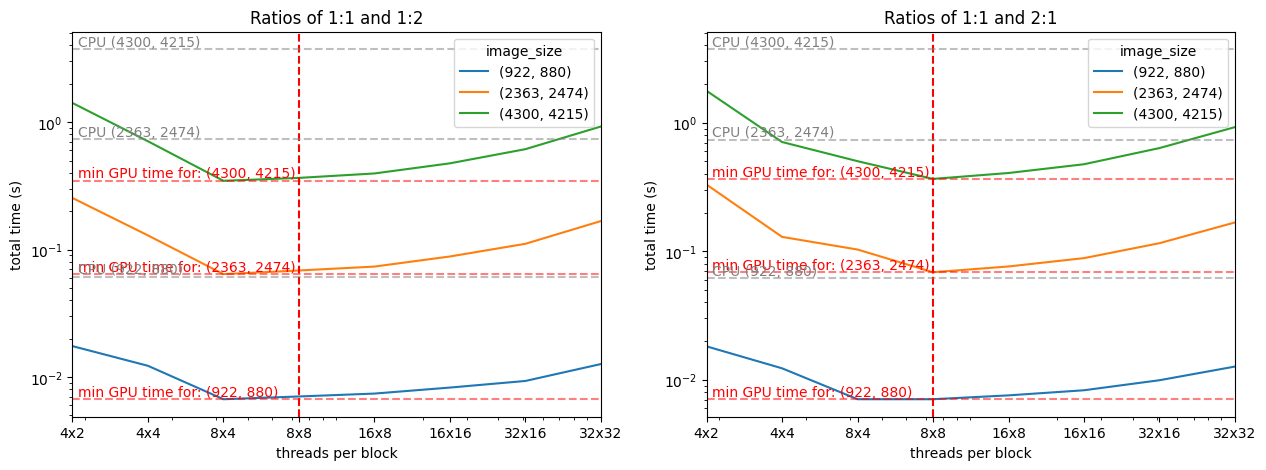

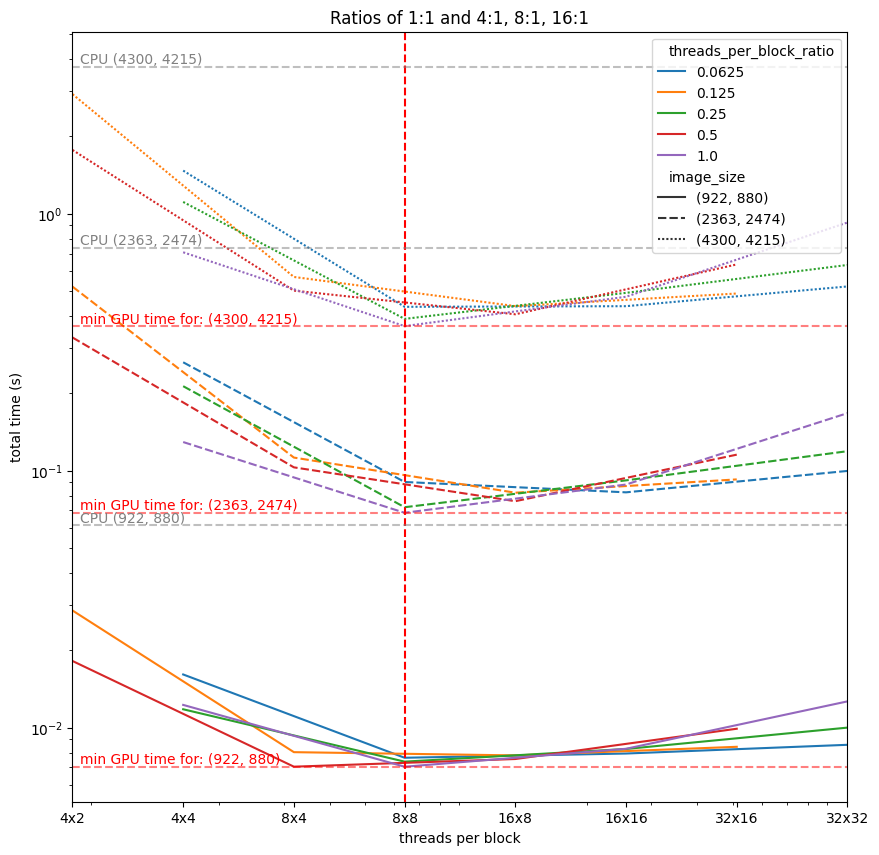

In [ ]:
df_shared_memory = convert_experiment_results_to_df(experiment_results_shared_memory)
plot_ratios(df_shared_memory)

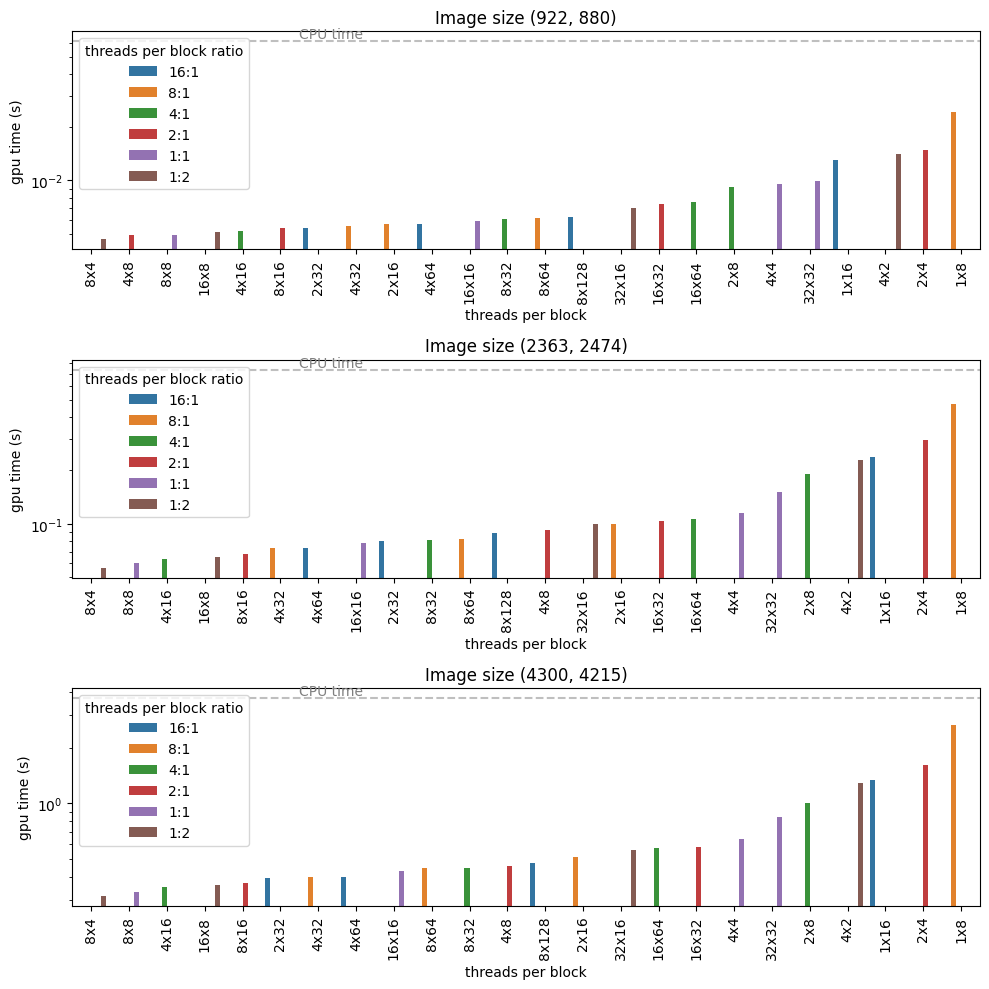

In [ ]:
plot_time_over_ratios(df_shared_memory)

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [ ]:
### BEGIN SOLUTION
# TODO what is the best way to do this? constant memory?
# - prefetch memory using 2 matrices
# - calculate more than one cell per thread
### END SOLUTION

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

In [ ]:
# first dump the images as a pickle file
with open('decomposition_test_image_3.pickle', 'wb') as f:
    pickle.dump(decompositions['test_image_3'], f)
with open('decomposition_test_image_2.pickle', 'wb') as f:
    pickle.dump(decompositions['test_image_2'], f)
with open('decomposition_test_image_1.pickle', 'wb') as f:
    pickle.dump(decompositions['test_image_1'], f)

In [ ]:
# ich finde es interessant, dass bei der Blockkonfiguration auch das Seitenverhältnis eine Rolle spielt
# deshalb analysiere ich die beste Blockkonfiguration und das umgekehrte Seitenverhältnis auf dem grössten Bild

# Test 1: 8x4
!nvprof --kernels .*__main__.* --analysis-metrics -o 8x4-%p.nvvp --profile-child-processes python .\nvprof_reconstruction.py 8 4

# Test 2: 4x8
!nvprof --kernels .*__main__.* --analysis-metrics -o 4x8-%p.nvvp --profile-child-processes python .\nvprof_reconstruction.py 4 8

Image size: 4083x4377
SVD shapes: (4083, 4083), (4083,), (4083, 4377)
Blocks per grid: (511, 1095)
Done!


======== Warning: GPU PC sampling feature is not available under multi-process profiling mode
and will be ignored.
==18424== NVPROF is profiling process 18424, command: C:\Program Files\Python310\python.exe .\nvprof_reconstruction.py 8 4
==18424== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.
==18424== Generated result file: d:\dev\hpc-m2\8x4-18424.nvvp


Image size: 4083x4377
SVD shapes: (4083, 4083), (4083,), (4083, 4377)
Blocks per grid: (1021, 548)
Done!


======== Warning: GPU PC sampling feature is not available under multi-process profiling mode
and will be ignored.
==13540== NVPROF is profiling process 13540, command: C:\Program Files\Python310\python.exe .\nvprof_reconstruction.py 4 8
==13540== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.
==13540== Generated result file: d:\dev\hpc-m2\4x8-13540.nvvp


In [ ]:
!nvvp -vm "C:\Program Files\Java\jre-1.8\bin\java"

<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [ ]:
### BEGIN SOLUTION
!nvprof -o streams-adni-%p.nvvp --profile-child-processes python .\streams.py adni
!nvprof -o streams-test-%p.nvvp --profile-child-processes python .\streams.py test
### END SOLUTION

<font color='blue'>Antwort hier eingeben</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>Antwort hier eingeben</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>Antwort hier eingeben inkl. Bild(ern).</font>
Komponenten können sein:
 - CPU-workers (processes)
 - MPS (Multi Process Service)
 - GPU Engines (Copy H2D, Compute kernel, Copy D2H)

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Antwort hier eingeben</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Antwort hier eingeben</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Antwort hier eingeben</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Antwort hier eingeben</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Antwort hier eingeben</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Antwort hier eingeben</font>